In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [101]:
q1 = 0.1
c1 = 1
q2 = 0.3
c2 = 0.1
rho = 800
kout = 0.1
Cp = 3200
T1 = 10
T2 = 40

V: 4.0, c: 0.325


Text(0, 0.5, 'c')

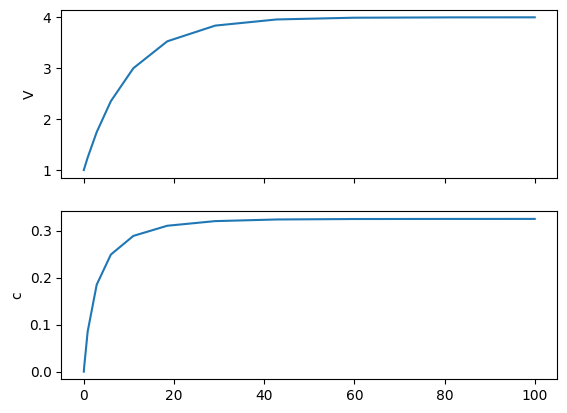

In [99]:
#Problem 1

def tank(t,y):
    V,c = y # y = (V,c)
    qout = kout * V

    dcdt = q1/V *(c1-c) + q2/V * (c2-c)
    dVdt = q1 + q2 - qout
   
    return dVdt, dcdt

def simtank():
    guess = (3,1)
    vsteady, csteady = fsolve(lambda y: tank(0,y), guess)
    print(f"V: {vsteady}, c: {csteady}")

simtank()

tspan = (0,100)
yinit = (1,0)
sol = solve_ivp(tank, tspan, yinit)

t = sol.t
V = sol.y[0]
c = sol.y[1]

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(t,V)
axs[0].set_ylabel('V')
axs[1].plot(t,c)
axs[1].set_ylabel('c')

V: 4.0, c: 0.32499999992164824, T: 32.499999999995765


Text(0, 0.5, 'T')

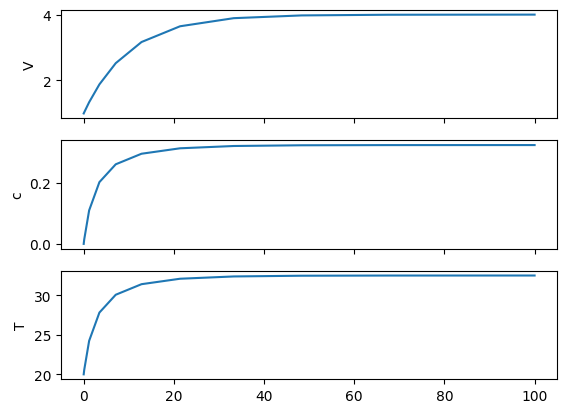

In [107]:
#Problem 2

def tank(t,y):
    V,c,T = y # y = (V,c)
    qout = kout * V

    dcdt = q1/V *(c1-c) + q2/V * (c2-c)
    dVdt = q1 + q2 - qout
    dTdt = q1/V*(T1-T)+q2/V*(T2-T) #(1/(rho*V*Cp))(Qr-Qc) INGEN REAKTION
   
    return dVdt, dcdt, dTdt

guess = (3,1,20)
vsteady, csteady, Tsteady = fsolve(lambda y: tank(0,y), guess)
print(f"V: {vsteady}, c: {csteady}, T: {Tsteady}")

tspan = (0,100)
yinit = (1,0,20)
sol = solve_ivp(tank, tspan, yinit)
t = sol.t
V = sol.y[0]
c = sol.y[1]
T = sol.y[2]

fig, axs = plt.subplots(3,1,sharex=True)
axs[0].plot(t,V)
axs[0].set_ylabel('V')
axs[1].plot(t,c)
axs[1].set_ylabel('c')
axs[2].plot(t,T)
axs[2].set_ylabel('T')


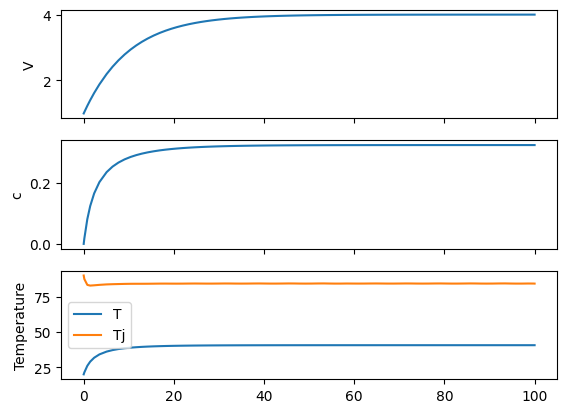

In [119]:
#Problem 3

kc = 5000
Ac = 50
Ti = 90
Cp = 4180
qj = 0.45
Vj = 0.2
rhoj = 1000

def tank(t,y):
    V,c,T,Tj  = y # y = (V,c)
    qout = kout * V

    dcdt = q1/V *(c1-c) + q2/V * (c2-c)
    dVdt = q1 + q2 - qout
    Qc = kc*Ac*(T-Tj)
    dTdt = q1/V*(T1-T)+q2/V*(T2-T) - Qc / (rho*V*Cp)
    dTjdt = qj/Vj*(Ti-Tj) + Qc / (rhoj*Vj*Cp)
   
    return dVdt, dcdt, dTdt, dTjdt

tspan = (0,100)
yinit = (1,0,20,90)
sol = solve_ivp(tank, tspan, yinit)
t = sol.t
V = sol.y[0]
c = sol.y[1]
T = sol.y[2]
Tj = sol.y[3]

fig, axs = plt.subplots(3,1,sharex=True)
axs[0].plot(t,V)
axs[0].set_ylabel('V')
axs[1].plot(t,c)
axs[1].set_ylabel('c')
axs[2].plot(t,T, label='T')
axs[2].set_ylabel('Temperature')
axs[2].plot(t,Tj, label='Tj')
axs[2].legend()


V: 3.7999939889375254, c: 0.49999675687618544, T: 24.851781387092334, Tj: 11.744344098244127, I: 0.059996443063711435


Text(0, 0.5, 'I')

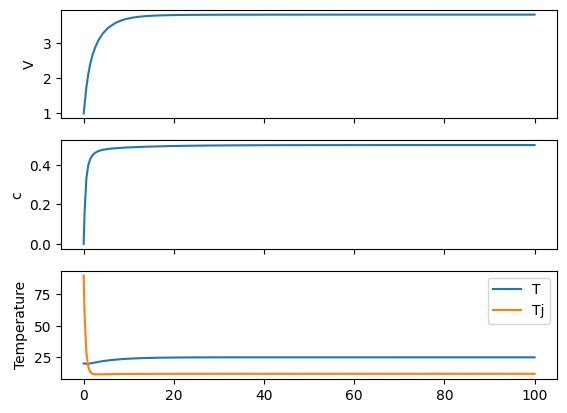

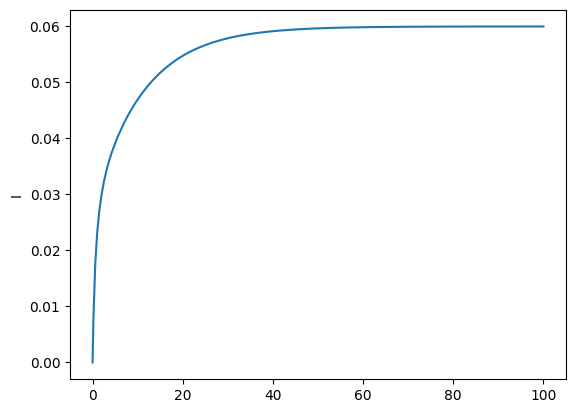

In [124]:
#Problem 4

Atank = 2
def tank(t,y):
    V,c,T,Tj, I  = y # y = (V,c)
    Qc = kc*Ac*(T-Tj)

    #Level controller
    href = 2
    uLmax = 0.6
    hmax = 4
    h = V / Atank
    yL = h / hmax
    yLref = href / hmax

    #P controller
    KL = 4
    uL = KL * (yLref - yL)

    #Saturation
    if uL < 0:
        uL = 0
    elif uL > 1:
        uL = 1

    #Reversed action controller
    uL = 1 - uL

    #Outflow
    qout = uLmax * uL

    #concenctration controller
    cref = 0.5
    cmax = 1
    yc = c  / cmax
    ycref = cref / cmax
    umax = 1

    #PI controller
    Kc = 4
    Ti = 10
    uC = Kc * ((ycref - yc) + I)

    #Saturation
    if uC < 0:
        uC = 0
    elif uC > 1:
        uC = 1

    #Input flow
    q1 = umax * uC
    
    dVdt = q1 + q2 - qout
    dcdt = q1/V *(c1-c) + q2/V * (c2-c)
    dTdt = q1/V*(T1-T)+q2/V*(T2-T) - Qc / (rho*V*Cp)
    dTjdt = qj/Vj*(Ti-Tj) + Qc / (rhoj*Vj*Cp)
    didt = 1/Ti * (ycref - yc)
   
    return dVdt, dcdt, dTdt, dTjdt, didt


tspan = (0,100)
yinit = (1,0,20,90, 0)
sol = solve_ivp(tank, tspan, yinit)
t = sol.t
V = sol.y[0]
c = sol.y[1]
T = sol.y[2]
Tj = sol.y[3]
I = sol.y[4]

print(f"V: {V[-1]}, c: {c[-1]}, T: {T[-1]}, Tj: {Tj[-1]}, I: {I[-1]}")
fig, axs = plt.subplots(3,1, sharex=True)
axs[0].plot(t,V)
axs[0].set_ylabel('V')
axs[1].plot(t,c)
axs[1].set_ylabel('c')
axs[2].plot(t,T, label='T')
axs[2].set_ylabel('Temperature')
axs[2].plot(t,Tj, label='Tj')
axs[2].legend()

fig, ax = plt.subplots()
ax.plot(t,I)
ax.set_ylabel('I')
